In [17]:
import pandas as pd

# Đọc dữ liệu từ file CSV đã tải lên
file_path = "data/filtered_data_northern_vietnam.csv"
df = pd.read_csv(file_path)

# Hiển thị một số dòng đầu để kiểm tra dữ liệu
df.head()


,Unnamed: 0,DATE,STATION,TMAX,TMIN,TAVG,PRCP,YEAR,MONTH,SEASON
0,5674,2013-01-01,VMM00048806,13.3,8.3,10.6,0.0,2013,1,Winter
1,5675,2013-01-02,VMM00048806,22.8,10.0,16.1,0.0,2013,1,Winter
2,5676,2013-01-03,VMM00048806,15.6,11.0,13.3,0.0,2013,1,Winter
3,5677,2013-01-04,VMM00048806,15.0,12.2,12.8,0.0,2013,1,Winter
4,5678,2013-01-05,VMM00048806,19.4,8.4,13.9,0.0,2013,1,Winter


In [18]:
# Hàm để điền giá trị thiếu cho TMAX, TMIN và TAVG
def fill_missing(df):
    if pd.isna(df['TAVG']) and pd.notna(df['TMAX']) and pd.notna(df['TMIN']):
        df['TAVG'] = (df['TMAX'] + df['TMIN'])/2
    if pd.isna(df['TMAX']) and pd.notna(df['TAVG']) and pd.notna(df['TMIN']):
        df['TMAX'] = 2*df['TAVG'] - df['TMIN']
    if pd.isna(df['TMIN']) and pd.notna(df['TAVG']) and pd.notna(df['TAVG']):
        df['TMIN'] = 2 * df['TAVG'] - df['TMAX']
    return df

# Áp dụng hàm fill_missing cho mỗi dòng
df = df.apply(fill_missing, axis=1)

# Loại bỏ các hàng có giá trị null trong bất kỳ cột nào
df = df.dropna(subset=['TMAX', 'TMIN', 'TAVG'])

df.to_csv('data/filtered_data_northern_vietnam.csv',index=False)



In [19]:

# Tính nhiệt độ trung bình, tối đa, tối thiểu theo mùa từng năm
seasonal_stats = df.groupby(['YEAR', 'SEASON']).agg(
    TAVG_mean=('TAVG', 'mean'),
    TMAX_max=('TMAX', 'max'),
    TMIN_min=('TMIN', 'min'),
    TEMP_range=('TAVG', lambda x: x.max() - x.min())
).reset_index()

# Làm tròn các giá trị
seasonal_stats = seasonal_stats.round(1)
seasonal_stats.head()


,YEAR,SEASON,TAVG_mean,TMAX_max,TMIN_min,TEMP_range
0,2013,Autumn,25.3,37.2,8.9,14.5
1,2013,Spring,21.8,36.7,6.6,20.5
2,2013,Summer,27.3,39.4,9.4,12.7
3,2013,Winter,16.4,31.1,-1.1,21.1
4,2014,Autumn,26.2,37.8,13.9,12.8


In [20]:
# Tính toán Q1, Q3 và IQR cho từng tỉnh
def calculate_seasonal_outliers(df, column, new_coloum):
    df[new_coloum] = False  # Khởi tạo cột IsOutlier mặc định là False
    for (year, season, station), group in df.groupby(['YEAR', 'SEASON','STATION']):
        q1 = group[column].quantile(0.25)
        q3 = group[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = (group[column] < lower_bound) | (group[column] > upper_bound)
        # Lọc các giá trị outlier
        df.loc[(df['YEAR'] == year) & (df['SEASON'] == season) &(df['STATION']==station)& outliers, new_coloum] = True
    return df

# Lấy các giá trị outlier cho từng tỉnh
df = calculate_seasonal_outliers(df,'TAVG','ISOUTLIER')
df = calculate_seasonal_outliers(df,'TMAX','ISOUTLIER_MAX')
df = calculate_seasonal_outliers(df,'TMIN','ISOUTLIER_MIN')
df.to_csv('data/filtered_data_northern_vietnam.csv',index=False)


In [21]:
# Xác định tần suất xuất hiện nhiệt độ cực đoan theo mùa
extreme_temp_counts = df[df['ISOUTLIER']].groupby(['YEAR', 'SEASON']).size().reset_index(name='extreme_count')

# Kết hợp với bảng seasonal_stats
seasonal_stats = seasonal_stats.merge(extreme_temp_counts, on=['YEAR', 'SEASON'], how='left')
seasonal_stats['extreme_count'] = seasonal_stats['extreme_count'].fillna(0).astype(int)



In [22]:
season_order = ["Spring", "Summer", "Autumn", "Winter"]
df['SEASON'] = pd.Categorical(df['SEASON'], categories=season_order, ordered=True)


In [23]:
# Vẽ các biểu đồ phân tích xu hướng
import matplotlib.pyplot as plt
import seaborn as sns

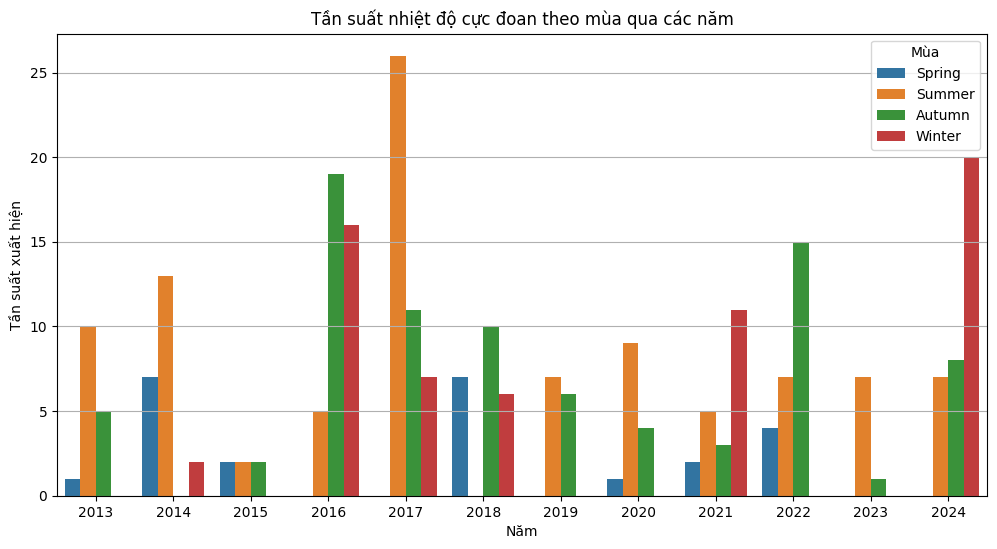

In [24]:
# Biểu đồ 2: So sánh tần suất nhiệt độ cực đoan giữa các mùa
plt.figure(figsize=(12, 6))
sns.barplot(data=seasonal_stats, x='YEAR', y='extreme_count', hue='SEASON', hue_order=season_order)
plt.title('Tần suất nhiệt độ cực đoan theo mùa qua các năm')
plt.xlabel('Năm')
plt.ylabel('Tần suất xuất hiện')
plt.legend(title='Mùa')
plt.grid(axis='y')
plt.show()


In [25]:
import numpy as np
from scipy.stats import linregress

# Tính xu hướng nhiệt độ theo từng mùa
def calculate_trend(data, season):
    seasonal_data = data[data['SEASON'] == season]
    if len(seasonal_data) > 1:  # Chỉ thực hiện nếu có đủ dữ liệu
        slope, intercept, r_value, p_value, std_err = linregress(seasonal_data['YEAR'], seasonal_data['TAVG_mean'])
        return slope  # Trả về độ dốc (slope) của hồi quy
    return np.nan

# Tính độ dốc xu hướng cho từng mùa
seasonal_trends = seasonal_stats.groupby('SEASON').apply(lambda x: calculate_trend(x, x.name)).reset_index(name='TAVG_trend')
seasonal_trends = seasonal_trends.dropna()  # Loại bỏ mùa không đủ dữ liệu
print("Xu hướng nhiệt độ trung bình theo mùa (°C/năm):")
print(seasonal_trends)



Xu hướng nhiệt độ trung bình theo mùa (°C/năm):
   SEASON  TAVG_trend
0  Autumn    0.063636
1  Spring    0.104895
2  Summer    0.037762
3  Winter    0.118531


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_972\2700719359.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seasonal_trends = seasonal_stats.groupby('SEASON').apply(lambda x: calculate_trend(x, x.name)).reset_index(name='TAVG_trend')


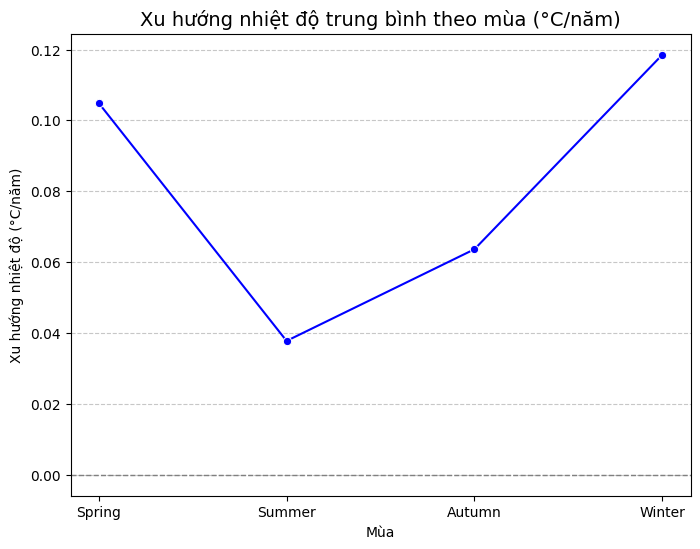

In [26]:
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
seasonal_trends['SEASON'] = pd.Categorical(
    seasonal_trends['SEASON'], 
    categories=season_order, 
    ordered=True
)
# Vẽ biểu đồ đường cho xu hướng nhiệt độ trung bình
plt.figure(figsize=(8, 6))

# Duyệt qua từng nhóm liên tục (không có khoảng trống giữa các mùa)
for _, group in seasonal_trends.dropna(subset=['TAVG_trend']).groupby((seasonal_trends['TAVG_trend'].isna()).cumsum()):
    sns.lineplot(
        data=group,
        x='SEASON',
        y='TAVG_trend',
        marker='o',
        color='b'
    )

# Thêm các thiết lập khác cho biểu đồ
plt.title("Xu hướng nhiệt độ trung bình theo mùa (°C/năm)", fontsize=14)
plt.xlabel("Mùa")
plt.ylabel("Xu hướng nhiệt độ (°C/năm)")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Đường tham chiếu tại 0
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



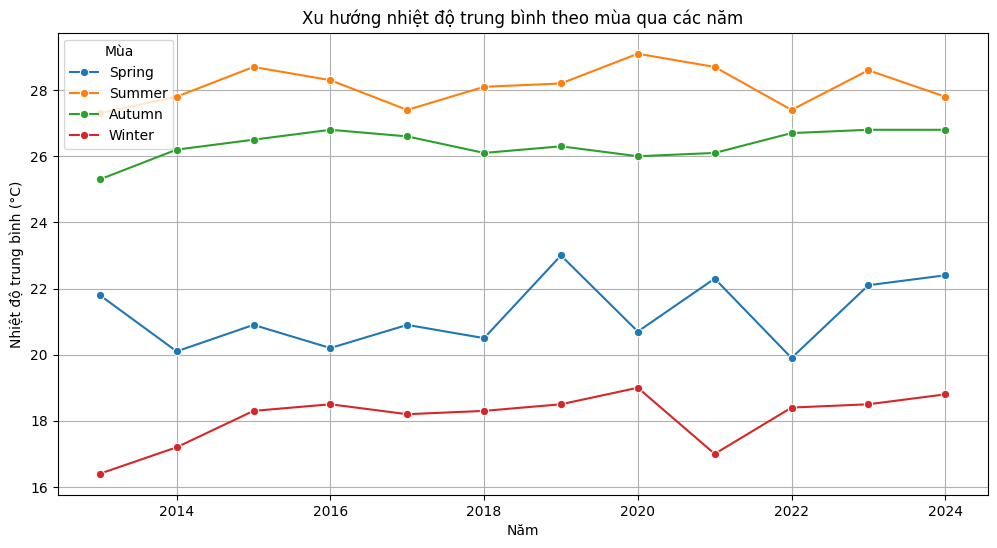

In [27]:
# Biểu đồ 1: Xu hướng nhiệt độ trung bình theo mùa qua các năm
plt.figure(figsize=(12, 6))
sns.lineplot(data=seasonal_stats, x='YEAR', y='TAVG_mean', hue='SEASON', marker='o', hue_order=season_order)
plt.title('Xu hướng nhiệt độ trung bình theo mùa qua các năm')
plt.xlabel('Năm')
plt.ylabel('Nhiệt độ trung bình (°C)')
plt.legend(title='Mùa')
plt.grid(True)
plt.show()


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_972\2052336617.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  season_corr = df.groupby('SEASON').apply(lambda x: x[['TAVG', 'PRCP']].corr().iloc[0, 1]).reset_index(name='Correlation')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_972\2052336617.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  season_corr = df.groupby('SEASON').apply(lambda x: x[['TAVG', 'PRCP']].corr().iloc[0, 1]).reset_index(name='Correlation')


Tương quan giữa nhiệt độ và lượng mưa theo mùa:
   SEASON  Correlation
0  Spring    -0.074900
1  Summer    -0.271531
2  Autumn    -0.098045
3  Winter    -0.062701


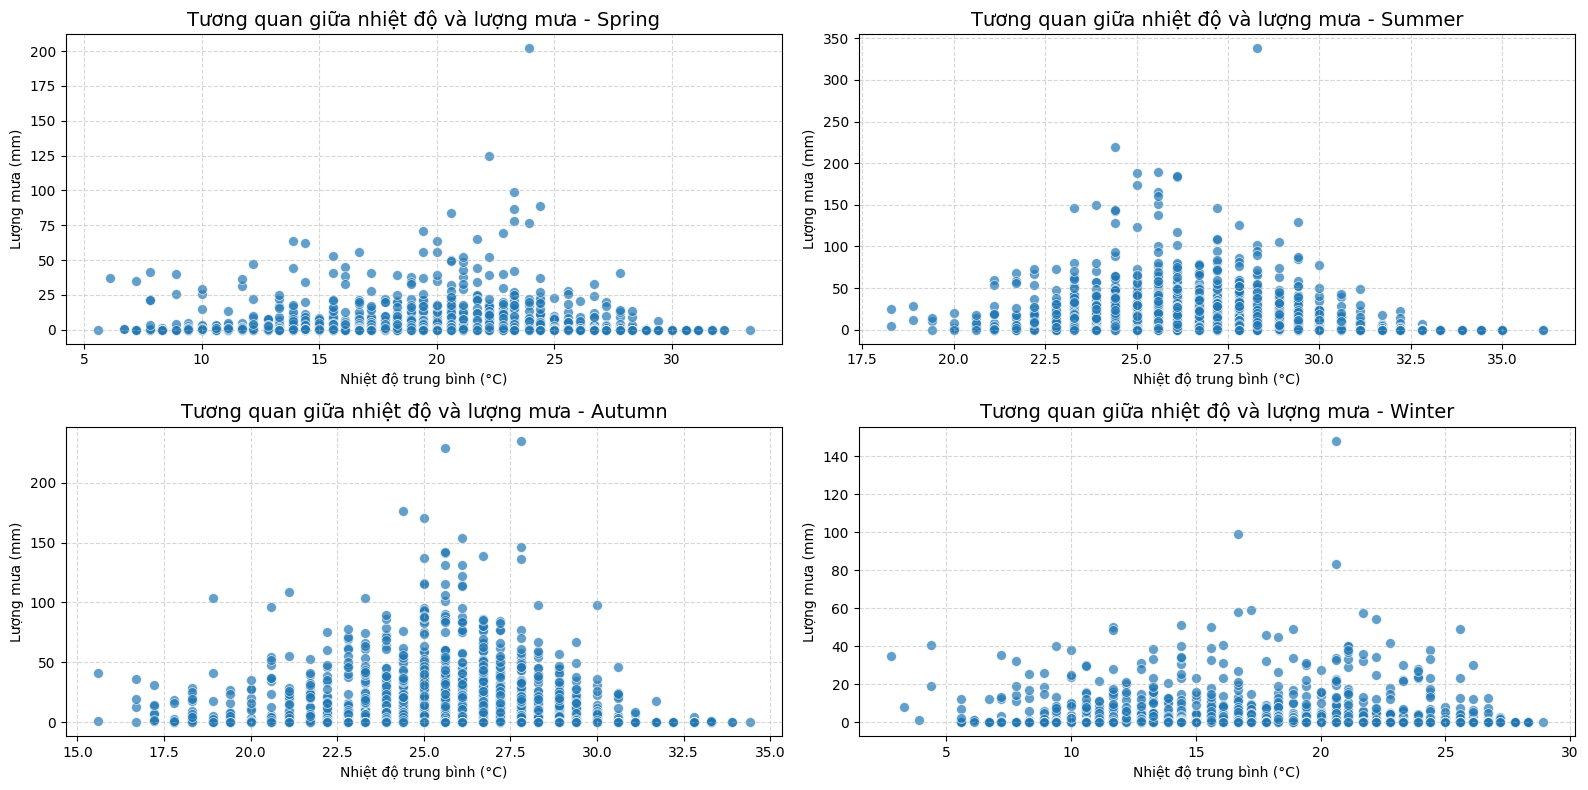

In [28]:
# Tính tương quan giữa TAVG và PRCP theo mùa
season_corr = df.groupby('SEASON').apply(lambda x: x[['TAVG', 'PRCP']].corr().iloc[0, 1]).reset_index(name='Correlation')

# Hiển thị bảng tương quan
print("Tương quan giữa nhiệt độ và lượng mưa theo mùa:")
print(season_corr)

# Vẽ biểu đồ phân tán (scatterplot) giữa TAVG và PRCP theo mùa
plt.figure(figsize=(16, 8))
for i, season in enumerate(season_order, 1):
    # Lấy dữ liệu theo mùa
    season_data = df[df['SEASON'] == season]
    
    # Vẽ biểu đồ scatter
    plt.subplot(2, 2, i)
    sns.scatterplot(data=season_data, x='TAVG', y='PRCP', alpha=0.7, s=50)
    plt.title(f"Tương quan giữa nhiệt độ và lượng mưa - {season}", fontsize=14)
    plt.xlabel("Nhiệt độ trung bình (°C)")
    plt.ylabel("Lượng mưa (mm)")
    plt.grid(True, linestyle="--", alpha=0.5)

# Điều chỉnh khoảng cách giữa các biểu đồ
plt.tight_layout()
plt.show()



C:\Users\ADMIN\AppData\Local\Temp\ipykernel_972\3045504855.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lambda x: x.groupby('SEASON')['TAVG'].mean().max() - x.groupby('SEASON')['TAVG'].mean().min()
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_972\3045504855.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_season_diff = df.groupby('YEAR').apply(


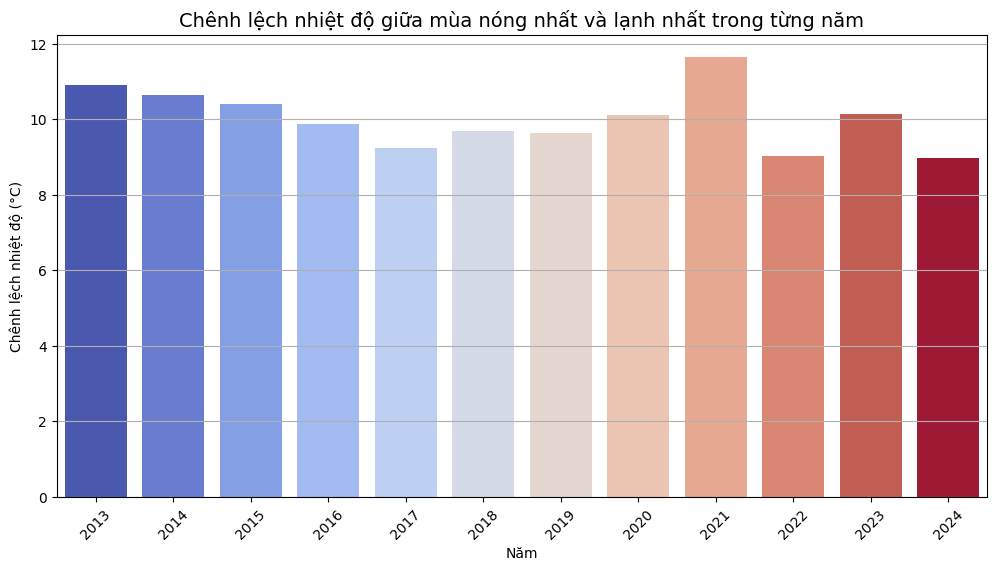

In [29]:
# Tính chênh lệch nhiệt độ giữa mùa nóng nhất và lạnh nhất trong cùng năm
yearly_season_diff = df.groupby('YEAR').apply(
    lambda x: x.groupby('SEASON')['TAVG'].mean().max() - x.groupby('SEASON')['TAVG'].mean().min()
).reset_index(name='Temp_Diff_Yearly')

# Vẽ biểu đồ cột chênh lệch nhiệt độ theo từng năm
plt.figure(figsize=(12, 6))
sns.barplot(
    data=yearly_season_diff,
    x='YEAR',
    y='Temp_Diff_Yearly',
    hue='YEAR',  # Thêm 'YEAR' làm hue
    palette='coolwarm',
    dodge=False  # Đảm bảo không chia các cột
)
plt.legend([], [], frameon=False)  # Loại bỏ chú thích
plt.title("Chênh lệch nhiệt độ giữa mùa nóng nhất và lạnh nhất trong từng năm", fontsize=14)
plt.xlabel("Năm")
plt.ylabel("Chênh lệch nhiệt độ (°C)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

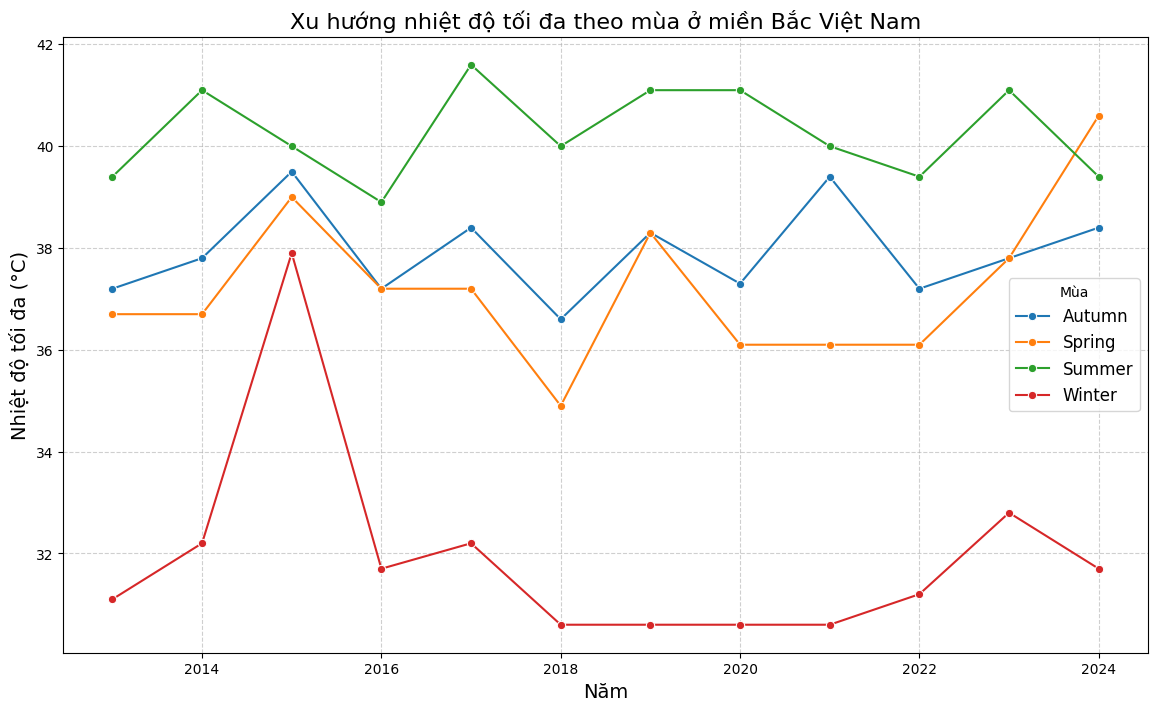

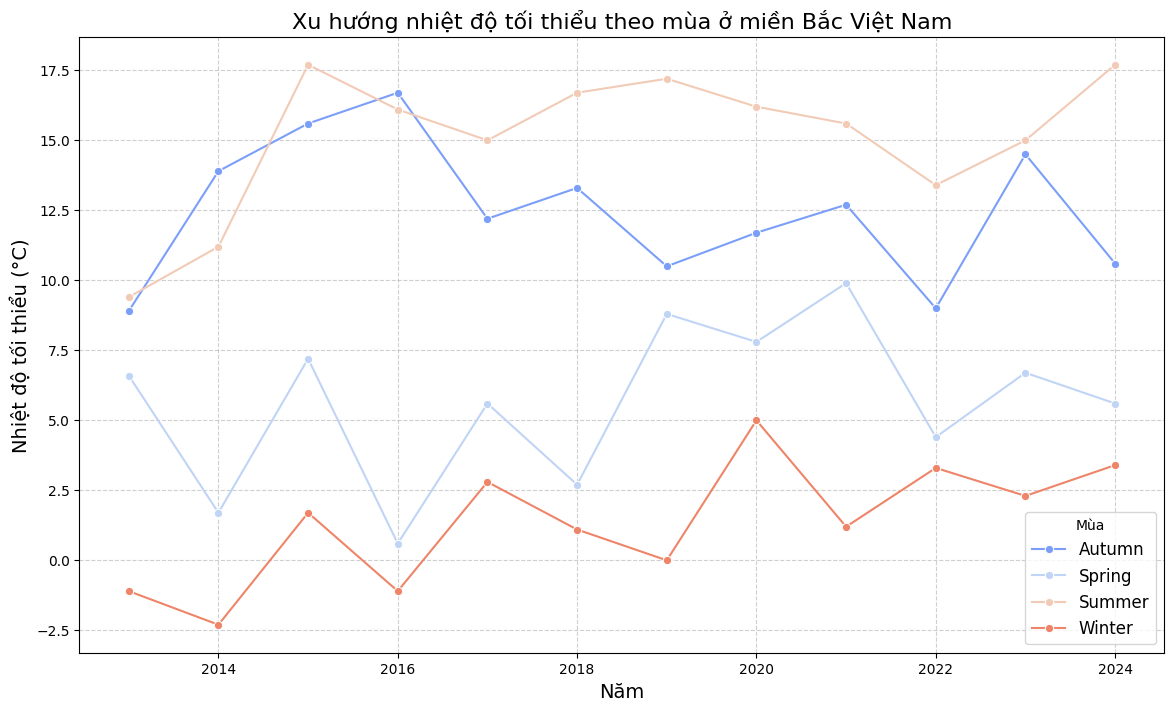

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Biểu đồ xu hướng nhiệt độ tối đa theo mùa qua các năm
plt.figure(figsize=(14, 8))
sns.lineplot(data=seasonal_stats, x='YEAR', y='TMAX_max', hue='SEASON', marker='o')
plt.title('Xu hướng nhiệt độ tối đa theo mùa ở miền Bắc Việt Nam', fontsize=16)
plt.xlabel('Năm', fontsize=14)
plt.ylabel('Nhiệt độ tối đa (°C)', fontsize=14)
plt.legend(title='Mùa', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Biểu đồ xu hướng nhiệt độ tối thiểu theo mùa qua các năm
plt.figure(figsize=(14, 8))
sns.lineplot(data=seasonal_stats, x='YEAR', y='TMIN_min', hue='SEASON', marker='o', palette='coolwarm')
plt.title('Xu hướng nhiệt độ tối thiểu theo mùa ở miền Bắc Việt Nam', fontsize=16)
plt.xlabel('Năm', fontsize=14)
plt.ylabel('Nhiệt độ tối thiểu (°C)', fontsize=14)
plt.legend(title='Mùa', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
